# **Install Library**

In [ ]:
from google.colab import drive
import zipfile
import os
import random
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_mobilenet

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input


In [ ]:
#mount Gdrive
drive.mount('/content/drive')
#drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
# melakukan ekstraksi pada file zip

local_zip = '/content/drive/MyDrive/fruits-360.zip' 
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()


In [ ]:
# menentukan direktori
base_dir = "/content"
train_dir = os.path.join(base_dir,'Training')
test_dir = os.path.join(base_dir, 'Test')

# **Membuat model**

In [ ]:
#total kelas
total_kelas = len(os.listdir(train_dir))
print("Jumlah kelas adalah {}".format(total_kelas))

Jumlah kelas adalah 131


In [ ]:
IMAGE_SIZE=[224, 224]
BATCH_SIZE=32

In [ ]:
#membuat generator
train_val_generator = ImageDataGenerator(
                                        preprocessing_function=preprocess_mobilenet,    
                                        rotation_range=30,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        shear_range=0.1,
                                        zoom_range=0.2,
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        fill_mode='nearest',
                                        validation_split=0.2
                                        )

test_generator  = ImageDataGenerator(preprocessing_function=preprocess_mobilenet)


In [ ]:
# setting sana sini pak
train_data = train_val_generator.flow_from_directory(train_dir, 
                                                    target_size=IMAGE_SIZE,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    color_mode='rgb',
                                                    subset='training',
                                                    shuffle=True,
                                                    )

val_data = train_val_generator.flow_from_directory(train_dir, 
                                                  target_size=IMAGE_SIZE,
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='categorical',
                                                  color_mode='rgb',
                                                  subset='validation',
                                                  shuffle=True,
                                                  )

test_data = test_generator.flow_from_directory(test_dir, 
                                               target_size=IMAGE_SIZE,
                                               batch_size=1,
                                               class_mode='categorical',
                                               color_mode='rgb',
                                               shuffle=False
                                               )

Found 54190 images belonging to 131 classes.
Found 13502 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


In [ ]:
#membuat pre-trained mobilenet
base_model = MobileNetV2(input_shape=IMAGE_SIZE + [3],
                         include_top=False,
                         weights='imagenet',
                         pooling='avg'
                         )

for layer in base_model.layers:
    layer.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
#menambah layer kita di akhir
x_input = base_model.input

output = Dense(total_kelas, activation='softmax')(base_model.output)

model = Model(x_input, output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#training model
hist = model.fit(train_data,
                 validation_data=val_data,
                 epochs=10, #enaknya berapa epochs?
                 verbose=1)

Epoch 1/10
1694/1694 [==============================] - 680s 383ms/step - loss: 0.4006 - accuracy: 0.9222 - val_loss: 0.1516 - val_accuracy: 0.9600
Epoch 2/10
1694/1694 [==============================] - 644s 380ms/step - loss: 0.0671 - accuracy: 0.9855 - val_loss: 0.1223 - val_accuracy: 0.9627
Epoch 3/10
1694/1694 [==============================] - 638s 376ms/step - loss: 0.0478 - accuracy: 0.9872 - val_loss: 0.0901 - val_accuracy: 0.9710
Epoch 4/10
1694/1694 [==============================] - 635s 375ms/step - loss: 0.0340 - accuracy: 0.9903 - val_loss: 0.0845 - val_accuracy: 0.9729
Epoch 5/10
1694/1694 [==============================] - 633s 374ms/step - loss: 0.0300 - accuracy: 0.9910 - val_loss: 0.0696 - val_accuracy: 0.9766
Epoch 6/10
1694/1694 [==============================] - 632s 373ms/step - loss: 0.0239 - accuracy: 0.9926 - val_loss: 0.0729 - val_accuracy: 0.9751
Epoch 7/10
1694/1694 [==============================] - 633s 374ms/step - loss: 0.0230 - accuracy: 0.9931 - val_

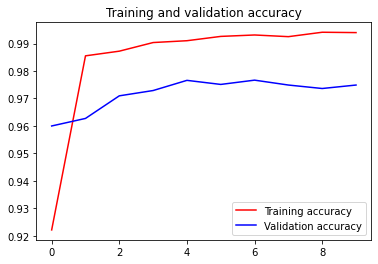

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

# Export Model (belum diedit)

In [ ]:
saved_model_dir = '/content/TFLite'
tf.saved_model.save(model, saved_model_dir)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: /content/TFLite/assets


# Convert Using TFLite's Converter

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

In [ ]:
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
labels = '\n'.join(sorted(train_data.class_indices.keys()))

In [ ]:
with open('labels.txt', 'w') as f:
  f.write(labels)

# Download model

In [ ]:
!zip -r /content/file.zip /content/TFLite

  adding: content/TFLite/ (stored 0%)
  adding: content/TFLite/assets/ (stored 0%)
  adding: content/TFLite/saved_model.pb (deflated 92%)
  adding: content/TFLite/variables/ (stored 0%)
  adding: content/TFLite/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/TFLite/variables/variables.index (deflated 77%)


In [ ]:
from google.colab import files
files.download("/content/model.tflite")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download("/content/labels.txt")

NameError: ignored

In [ ]:
files.download("/content/file.zip")

# Test the TFLite Model Using the Python Interpreter